# Relevamiento geolocalizado de Techos solares en la Ciudad Autónoma de Buenos Aires.

## Ciencia de Datos - Ingeniería Industrial UTN BA


### Grupo 2: Alan Maggio

### Se utilizarán los siguientes dataset de BA Ciudad para evaluar el progreso y la distribución de los techos solares en la capital:

* https://data.buenosaires.gob.ar/dataset/mapa-techos-solares

* https://data.buenosaires.gob.ar/dataset/barrios


Se utilizará un dataset de "BA data" en el cual se encuentra el relevamiento geolocalizado de las instalaciones solares existentes en la ciudad de Buenos Aires. En dicho dataset se encuentran tanto las instalaciones solares fotovoltaicas como las instalaciones solares térmicas.

Para poder complementar el análisis del dataset se utilizará la herramienta "Geopandas" la cual trabaja con datos Geoespaciales. Se combinará la geolocalizacion de los techos disponible en el dataset con mapas de barrios y comunas tambien a disposicion en BA data.

#### Primero importaremos las librerias necesarias para desarrollar el analisis:

In [1]:
#Datos
import pandas as pd
import numpy as np
#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Geolocalización
import geopandas as gpd
#Ocultar mensajes de advertencia
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
>>> 'geopandas' in sys.modules

True

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [4]:
# Importamos librerias de Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

In [5]:
# Importamos librerias de PCA y silhouette_score
from sklearn.decomposition import PCA
from  sklearn.metrics import silhouette_score

# Dataset

### Importamos el datasets que utilizaremos:

In [6]:
#Relevamiento geolocalizado de las instalaciones solares (fotovoltaicas y térmicas)
techos_solares_data = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/agencia-de-proteccion-ambiental/mapa-techos-solares/techos_inteligentes_amarillos_WGS84.geojson"

In [7]:
techos_solares = gpd.read_file(techos_solares_data)

#### Confirmamos que se hayan cargado bien los datos, contamos la cantidad de filas y columnas, y visualizamos las primeras 5 filas de nuestro Dataset:

In [8]:
print("El dataset de Techos Solares contiene "
      +  str(np.shape(techos_solares)[0])
      + " filas y " + str(np.shape(techos_solares)[1])
      + " columnas","\n")

El dataset de Techos Solares contiene 81 filas y 24 columnas 



In [10]:
techos_solares.head()

,WKT,id_techo,tipo_edifi,tipo_techo,edificio,direccion,tipo_siste,capacidad,caracteris,proveedor,...,altura,calle2,direccion_,barrio,comuna,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq,geometry
0,POINT (-58.4662102207881 -34.6639068022041),1,Público,Solar Fotovoltaico,CIFA,Av Escalada y Av Castañares,On-Grid,19660 Wp,"- INSTALACION SOLAR FOTOVOLTAICA ""Paneles conv...",ALDAR,...,,CASTAÑARES AV.,ESCALADA AV. y CASTAÑARES AV.,Villa Soldati,Comuna 8,31025,13.96,310250,139.60,POINT (-58.46621 -34.66391)
1,POINT (-58.3746633515549 -34.6095181480613),2,Público,Solar Fotovoltaico,Legislatura de la Ciudad de Buenos Aires,Perú 130,On-Grid,26000 Wp,96 módulos de silicio policristalino de 270 Wp...,SOLARTEC,...,130,,PERU 130,Monserrat,Comuna 1,48400,23.47,338800,164.29,POINT (-58.37466 -34.60952)
2,POINT (-58.458914509259 -34.5826131064903),3,Privado,Solar Fotovoltaico,Fundación Greenpeace Argentina,Zabala 3873,On-Grid,1700 Wp,750Wp: 10 módulos fotovoltaicos KS 75 (celdas ...,Desarrollo Greenpowerinstalación Sursolar,...,3873,,ZABALA 3873,Chacarita,Comuna 15,2635,1.18,42160,18.88,POINT (-58.45891 -34.58261)
3,POINT (-58.4589145092589 -34.5826131064903),3 BIS,Privado,Solar Fotovoltaico,Fundación Greenpeace Argentina,Zabala 3873,Off-Grid,120 Wp,Instalación fotovoltaica autónoma que alimenta...,Desarrollo Greenpowerinstalación Sursolar,...,3873,,ZABALA 3873,Chacarita,Comuna 15,186,0.08,2976,1.34,POINT (-58.45891 -34.58261)
4,POINT (-58.37235210010887 -34.60303182417196),4,Privado,Solar Fotovoltaico,Aseguradora Allianz,Corrientes 299,On-Grid,520 Wp,Paneles fotovoltaicos para la iluminacion led ...,WulconEnergy,...,299,,CORRIENTES AV. 299,San Nicolas,Comuna 1,735,0.33,3675,1.65,POINT (-58.37235 -34.60303)


# Pre procesamiento

In [11]:
# Visualización de los nombres de las columnas
nombre_columnas_solares = techos_solares.columns.values
nombre_columnas_solares

array(['WKT', 'id_techo', 'tipo_edifi', 'tipo_techo', 'edificio',
       'direccion', 'tipo_siste', 'capacidad', 'caracteris', 'proveedor',
       'fecha_inst', 'link', 'foto', 'calle', 'altura', 'calle2',
       'direccion_', 'barrio', 'comuna', 'energia_an_kwh',
       'mitig_an_tCO2eq', 'energia_acum_kwh', 'mitig_acum_tCO2eq',
       'geometry'], dtype=object)

In [12]:
techos_solares.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   WKT                81 non-null     object  
 1   id_techo           81 non-null     object  
 2   tipo_edifi         81 non-null     object  
 3   tipo_techo         81 non-null     object  
 4   edificio           81 non-null     object  
 5   direccion          81 non-null     object  
 6   tipo_siste         81 non-null     object  
 7   capacidad          81 non-null     object  
 8   caracteris         81 non-null     object  
 9   proveedor          81 non-null     object  
 10  fecha_inst         81 non-null     object  
 11  link               81 non-null     object  
 12  foto               81 non-null     object  
 13  calle              81 non-null     object  
 14  altura             81 non-null     object  
 15  calle2             81 non-null     object  
 16  di

In [13]:
#Procesamiento de las coordeandas de la ubicacion del techo para poder tener la coordenada vert. y horiz.
techos_solares.WKT = techos_solares.WKT.str.replace("POINT","")
techos_solares.WKT = techos_solares.WKT.str.replace("(","")
techos_solares.WKT = techos_solares.WKT.str.replace(")","")

print("Dataset Techos Inteligentes: ")
techos_solares.head(1)

Dataset Techos Inteligentes: 


,WKT,id_techo,tipo_edifi,tipo_techo,edificio,direccion,tipo_siste,capacidad,caracteris,proveedor,...,altura,calle2,direccion_,barrio,comuna,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq,geometry
0,-58.4662102207881 -34.6639068022041,1,Público,Solar Fotovoltaico,CIFA,Av Escalada y Av Castañares,On-Grid,19660 Wp,"- INSTALACION SOLAR FOTOVOLTAICA ""Paneles conv...",ALDAR,...,,CASTAÑARES AV.,ESCALADA AV. y CASTAÑARES AV.,Villa Soldati,Comuna 8,31025,13.96,310250,139.60,POINT (-58.46621 -34.66391)


In [14]:
#Generacion de un nuevo data frame con las coordenadas
coord_intel = techos_solares.WKT.str.split(expand=True)
coord_intel.columns=["Horiz","Vert"]
coord_intel.Horiz=coord_intel.Horiz.astype(float)
coord_intel.Vert=coord_intel.Vert.astype(float)
coord_intel.head()

,Horiz,Vert
0,-58.466210,-34.663907
1,-58.374663,-34.609518
2,-58.458915,-34.582613
3,-58.458915,-34.582613
4,-58.372352,-34.603032


In [15]:
#Concatenación de las coordenadas al final del data frame
techos_solares = pd.concat([techos_solares,coord_intel],axis=1)
techos_solares.head(1)

,WKT,id_techo,tipo_edifi,tipo_techo,edificio,direccion,tipo_siste,capacidad,caracteris,proveedor,...,direccion_,barrio,comuna,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq,geometry,Horiz,Vert
0,-58.4662102207881 -34.6639068022041,1,Público,Solar Fotovoltaico,CIFA,Av Escalada y Av Castañares,On-Grid,19660 Wp,"- INSTALACION SOLAR FOTOVOLTAICA ""Paneles conv...",ALDAR,...,ESCALADA AV. y CASTAÑARES AV.,Villa Soldati,Comuna 8,31025,13.96,310250,139.60,POINT (-58.46621 -34.66391),-58.46621,-34.663907


In [16]:
#Reorganización de las columnas del dataset
techos_solares = techos_solares[['geometry', 'Horiz', 'Vert', 'WKT', 'id_techo', 'tipo_edifi', 'tipo_techo', 'fecha_inst'
                                 , 'barrio', 'comuna','edificio', 'direccion', 'tipo_siste', 'capacidad', 'caracteris'
                                 , 'proveedor', 'link', 'foto', 'calle', 'altura', 'calle2', 'direccion_', 'energia_an_kwh'
                                 , 'mitig_an_tCO2eq', 'energia_acum_kwh', 'mitig_acum_tCO2eq']]

#Eliminación de las columnas que no se utilizarán
techos_solares = techos_solares.drop(["WKT",'id_techo', "edificio","direccion","caracteris","proveedor","link", "foto"
                                      , "calle", "altura", "calle2", "direccion_" ,"capacidad"],axis=1)

techos_solares.head(2)

,geometry,Horiz,Vert,tipo_edifi,tipo_techo,fecha_inst,barrio,comuna,tipo_siste,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq
0,POINT (-58.46621 -34.66391),-58.466210,-34.663907,Público,Solar Fotovoltaico,2011,Villa Soldati,Comuna 8,On-Grid,31025,13.96,310250,139.60
1,POINT (-58.37466 -34.60952),-58.374663,-34.609518,Público,Solar Fotovoltaico,2014,Monserrat,Comuna 1,On-Grid,48400,23.47,338800,164.29


In [17]:
print(techos_solares.columns,"\n")

Index(['geometry', 'Horiz', 'Vert', 'tipo_edifi', 'tipo_techo', 'fecha_inst',
       'barrio', 'comuna', 'tipo_siste', 'energia_an_kwh', 'mitig_an_tCO2eq',
       'energia_acum_kwh', 'mitig_acum_tCO2eq'],
      dtype='object') 



In [18]:
#Revisión de los "nan" del dataset
col_NaN = techos_solares.isna().any()
print(col_NaN,'\r\n')

geometry             False
Horiz                False
Vert                 False
tipo_edifi           False
tipo_techo           False
fecha_inst           False
barrio               False
comuna               False
tipo_siste           False
energia_an_kwh       False
mitig_an_tCO2eq      False
energia_acum_kwh     False
mitig_acum_tCO2eq    False
dtype: bool 



In [19]:
# Revisión de valores nulos
col_nulls = techos_solares.isnull().sum().sort_values(ascending=False)
print(col_nulls,'\r\n')

geometry             0
Horiz                0
Vert                 0
tipo_edifi           0
tipo_techo           0
fecha_inst           0
barrio               0
comuna               0
tipo_siste           0
energia_an_kwh       0
mitig_an_tCO2eq      0
energia_acum_kwh     0
mitig_acum_tCO2eq    0
dtype: int64 



In [20]:
#Modificación de los nombres de algunas columnas para que sean mas intuitivos
techos_solares = techos_solares.rename(columns={"tipo_edifi":"publ_priv" , 'tipo_techo':'tipo_tecnologia','tipo_siste':'tipo_conexion'})
techos_solares.head(1)

,geometry,Horiz,Vert,publ_priv,tipo_tecnologia,fecha_inst,barrio,comuna,tipo_conexion,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq
0,POINT (-58.46621 -34.66391),-58.46621,-34.663907,Público,Solar Fotovoltaico,2011,Villa Soldati,Comuna 8,On-Grid,31025,13.96,310250,139.60


In [21]:
#Analisís de la paridad de los datos
a = len(techos_solares['publ_priv'].unique())
b = len(techos_solares['tipo_tecnologia'].unique())
c = len(techos_solares['comuna'].unique())
d = len(techos_solares['tipo_conexion'].unique())
e = len(techos_solares['barrio'].unique())

print(f'En total hay {a} tipos de valores en "publ_priv"')
print(techos_solares['publ_priv'].value_counts(),"\r\n")

print(f'En total hay {b} tipos de valores en "tipo_tecnologia"')
print(techos_solares['tipo_tecnologia'].value_counts(),"\r\n")

print(f'En total hay {c} tipos de valores en "comuna"')
print(techos_solares['comuna'].value_counts().sort_index(ascending=True),"\r\n")

print(f'En total hay {d} tipos de valores en "tipo_conexion"')
print(techos_solares['tipo_conexion'].value_counts(),"\r\n")

print(f'En total hay {e} tipos de valores en "barrio"')
print(techos_solares['barrio'].value_counts().sort_index(ascending=True),"\r\n")

En total hay 2 tipos de valores en "publ_priv"
Público    51
Privado    30
Name: publ_priv, dtype: int64 

En total hay 2 tipos de valores en "tipo_tecnologia"
Solar Fotovoltaico    55
Solar Térmico         26
Name: tipo_tecnologia, dtype: int64 

En total hay 16 tipos de valores en "comuna"
             12
Comuna 1     12
Comuna 10     1
Comuna 11     2
Comuna 12     4
Comuna 13     5
Comuna 14    10
Comuna 15     5
Comuna 2      2
Comuna 3      2
Comuna 4      7
Comuna 5      1
Comuna 6      2
Comuna 7      8
Comuna 8      4
Comuna 9      4
Name: comuna, dtype: int64 

En total hay 3 tipos de valores en "tipo_conexion"
On-Grid     38
            28
Off-Grid    15
Name: tipo_conexion, dtype: int64 

En total hay 37 tipos de valores en "barrio"
                     12
ALMAGRO               1
BARRACAS              1
BELGRANO              2
Balvanera             1
Boca                  2
CABALLITO             1
COGHLAN               1
COLEGIALES            1
CONSTITUCION          1
Cabal

In [22]:
#Limpieza de los valores de la columna Barrios
techos_solares.barrio = techos_solares.barrio.str.replace("FLORES","Flores")
techos_solares.barrio = techos_solares.barrio.str.replace("CABALLITO","Caballito")
techos_solares.barrio = techos_solares.barrio.str.replace("PALERMO","Palermo")
techos_solares.barrio = techos_solares.barrio.str.replace("PARQUE AVELLANEDA","Parque Avellaneda")
techos_solares.barrio = techos_solares.barrio.str.replace("RECOLETA","Recoleta")
techos_solares.barrio = techos_solares.barrio.str.replace("VILLA CRESPO","Villa Crespo")

techos_solares['nombre_barrio']= techos_solares['barrio'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
techos_solares['nombre_barrio']= techos_solares['nombre_barrio'].str.upper()

f = len(techos_solares['nombre_barrio'].unique())

print(f'En total hay {f} tipos de valores en "nombre_barrio"', "\n")
print("Ahora los valores de la columna 'barrio' son: \n", techos_solares.nombre_barrio.unique())

En total hay 31 tipos de valores en "nombre_barrio" 

Ahora los valores de la columna 'barrio' son: 
 ['VILLA SOLDATI' 'MONSERRAT' 'CHACARITA' 'SAN NICOLAS' 'CABALLITO'
 'PALERMO' 'BALVANERA' 'BARRACAS' 'BOCA' 'VILLA CRESPO' 'FLORES'
 'PARQUE CHAS' 'PARQUE CHACABUCO' 'SAAVEDRA' 'PARQUE AVELLANEDA' 'RETIRO'
 'VILLA URQUIZA' 'FLORESTA' 'SAN CRISTOBAL' 'NUEVA POMPEYA' 'COGHLAN'
 'BELGRANO' 'RECOLETA' '' 'PARQUE PATRICIOS' 'CONSTITUCION' 'VILLA DEVOTO'
 'NUNEZ' 'ALMAGRO' 'VILLA PUEYRREDON' 'COLEGIALES']


In [23]:
# Eliminación de columna "barrio" que está repetida
techos_solares = techos_solares.drop(["barrio"],axis=1)
techos_solares.head()

,geometry,Horiz,Vert,publ_priv,tipo_tecnologia,fecha_inst,comuna,tipo_conexion,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq,nombre_barrio
0,POINT (-58.46621 -34.66391),-58.466210,-34.663907,Público,Solar Fotovoltaico,2011,Comuna 8,On-Grid,31025,13.96,310250,139.60,VILLA SOLDATI
1,POINT (-58.37466 -34.60952),-58.374663,-34.609518,Público,Solar Fotovoltaico,2014,Comuna 1,On-Grid,48400,23.47,338800,164.29,MONSERRAT
2,POINT (-58.45891 -34.58261),-58.458915,-34.582613,Privado,Solar Fotovoltaico,2005,Comuna 15,On-Grid,2635,1.18,42160,18.88,CHACARITA
3,POINT (-58.45891 -34.58261),-58.458915,-34.582613,Privado,Solar Fotovoltaico,2005,Comuna 15,Off-Grid,186,0.08,2976,1.34,CHACARITA
4,POINT (-58.37235 -34.60303),-58.372352,-34.603032,Privado,Solar Fotovoltaico,2016,Comuna 1,On-Grid,735,0.33,3675,1.65,SAN NICOLAS


In [24]:
#Generacion de un nuevo "numero de comuna" arbitrario para las filas con comuna no especificada
techos_solares.comuna = techos_solares.comuna.str.replace('Comuna ','')
techos_solares.comuna.replace('', np.nan, inplace = True )
techos_solares.comuna.replace(np.nan, '99', inplace = True )

g = len(techos_solares['comuna'].unique())

print(f'En total hay {g} tipos de valores en "comuna"', "\n")
print("Ahora los valores de la columna 'comuna' son: \n", techos_solares.comuna.unique())

En total hay 16 tipos de valores en "comuna" 

Ahora los valores de la columna 'comuna' son: 
 ['8' '1' '15' '6' '14' '3' '4' '7' '12' '9' '10' '13' '2' '99' '11' '5']


In [25]:
#Generacion de una nueva clasificacion de "tipo de conexión" para las filas sin especificación
techos_solares.tipo_conexion.replace('', np.nan, inplace = True)
techos_solares.tipo_conexion.replace(np.nan, "Sin especificar", inplace = True)

h = len(techos_solares['tipo_conexion'].unique())

print(f'En total hay {h} tipos de valores en "tipo_siste"', "\n")
print("Ahora los valores de la columna 'tipo_siste' son: \n", techos_solares.tipo_conexion.unique())

En total hay 3 tipos de valores en "tipo_siste" 

Ahora los valores de la columna 'tipo_siste' son: 
 ['On-Grid' 'Off-Grid' 'Sin especificar']


In [26]:
#Vemos como nos quedó el data sets luego de la limpieza
print("Ahora el dataset de Techos Solares contiene "
      +  str(np.shape(techos_solares)[0])
      + " filas y " + str(np.shape(techos_solares)[1])
      + " columnas","\n")

Ahora el dataset de Techos Solares contiene 81 filas y 13 columnas 



In [27]:
#Tipos de datos para cada columna del dataframe techos_solares
techos_solares.dtypes

geometry             geometry
Horiz                 float64
Vert                  float64
publ_priv              object
tipo_tecnologia        object
fecha_inst             object
comuna                 object
tipo_conexion          object
energia_an_kwh         object
mitig_an_tCO2eq        object
energia_acum_kwh       object
mitig_acum_tCO2eq      object
nombre_barrio          object
dtype: object

In [28]:
# Formateo de los datos del dataset
techos_solares.fecha_inst=techos_solares.fecha_inst.astype('int64')
techos_solares.nombre_barrio=techos_solares.nombre_barrio.astype('category')
techos_solares.comuna=techos_solares.comuna.astype('int64')
techos_solares.publ_priv=techos_solares.publ_priv.astype('category')
techos_solares.energia_an_kwh=techos_solares.energia_an_kwh.astype('float')
techos_solares.mitig_an_tCO2eq=techos_solares.mitig_an_tCO2eq.astype('float')
techos_solares.energia_acum_kwh=techos_solares.energia_acum_kwh.astype('float')
techos_solares.mitig_acum_tCO2eq=techos_solares.mitig_acum_tCO2eq.astype('float')


In [29]:
techos_solares.head()

,geometry,Horiz,Vert,publ_priv,tipo_tecnologia,fecha_inst,comuna,tipo_conexion,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq,nombre_barrio
0,POINT (-58.46621 -34.66391),-58.466210,-34.663907,Público,Solar Fotovoltaico,2011,8,On-Grid,31025.0,13.96,310250.0,139.60,VILLA SOLDATI
1,POINT (-58.37466 -34.60952),-58.374663,-34.609518,Público,Solar Fotovoltaico,2014,1,On-Grid,48400.0,23.47,338800.0,164.29,MONSERRAT
2,POINT (-58.45891 -34.58261),-58.458915,-34.582613,Privado,Solar Fotovoltaico,2005,15,On-Grid,2635.0,1.18,42160.0,18.88,CHACARITA
3,POINT (-58.45891 -34.58261),-58.458915,-34.582613,Privado,Solar Fotovoltaico,2005,15,Off-Grid,186.0,0.08,2976.0,1.34,CHACARITA
4,POINT (-58.37235 -34.60303),-58.372352,-34.603032,Privado,Solar Fotovoltaico,2016,1,On-Grid,735.0,0.33,3675.0,1.65,SAN NICOLAS


In [30]:
techos_solares.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   geometry           81 non-null     geometry
 1   Horiz              81 non-null     float64 
 2   Vert               81 non-null     float64 
 3   publ_priv          81 non-null     category
 4   tipo_tecnologia    81 non-null     object  
 5   fecha_inst         81 non-null     int64   
 6   comuna             81 non-null     int64   
 7   tipo_conexion      81 non-null     object  
 8   energia_an_kwh     81 non-null     float64 
 9   mitig_an_tCO2eq    81 non-null     float64 
 10  energia_acum_kwh   81 non-null     float64 
 11  mitig_acum_tCO2eq  81 non-null     float64 
 12  nombre_barrio      81 non-null     category
dtypes: category(2), float64(6), geometry(1), int64(2), object(2)
memory usage: 8.7+ KB


# Análisis exploratorio de datos

                      Horiz      Vert  fecha_inst    comuna  energia_an_kwh  \
Horiz              1.000000  0.069738    0.024830  0.217599        0.207275   
Vert               0.069738  1.000000    0.292253  0.192804        0.136374   
fecha_inst         0.024830  0.292253    1.000000  0.226589        0.225138   
comuna             0.217599  0.192804    0.226589  1.000000        0.375060   
energia_an_kwh     0.207275  0.136374    0.225138  0.375060        1.000000   
mitig_an_tCO2eq    0.207124  0.136017    0.224700  0.373518        0.999892   
energia_acum_kwh   0.217327  0.115338    0.195641  0.334592        0.977234   
mitig_acum_tCO2eq  0.217871  0.114923    0.194653  0.332726        0.976188   

                   mitig_an_tCO2eq  energia_acum_kwh  mitig_acum_tCO2eq  
Horiz                     0.207124          0.217327           0.217871  
Vert                      0.136017          0.115338           0.114923  
fecha_inst                0.224700          0.195641           0.1

<AxesSubplot:>

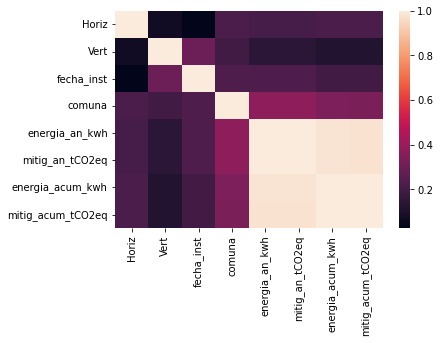

In [31]:
#Imprimimos la matriz de correlación para ver si existen variables correlacioandas
corr = techos_solares.corr()
print(corr)
sns.heatmap(corr)

In [32]:
sns.set_theme(style="whitegrid", palette="pastel")

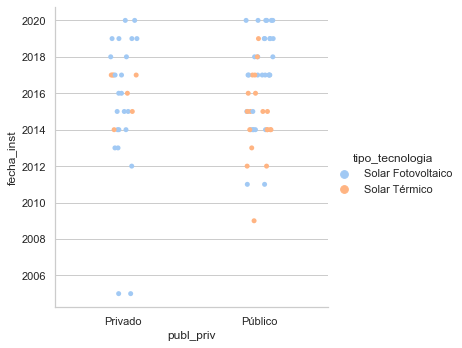

In [33]:
# Visualización de las principales etiquetas por año de instalación
g = sns.catplot(x="publ_priv", y="fecha_inst", hue="tipo_tecnologia" , data=techos_solares)

En el catplot anterior, se puede observar cómo la mayor cantidad de los techos, como era de esperarse, fueron instalados en los ultimos años. Algo que tambien se puede destacar es que hay mas densidad de techos en edificios públicos que en privados.

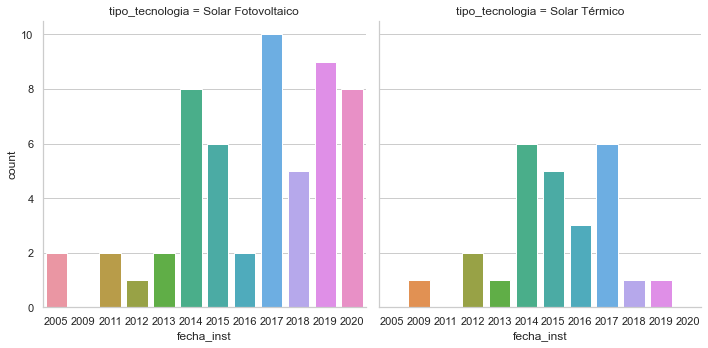

In [34]:
# Contabilización de techos por año en que fueron instalados, separado en Solar Fotovoltaico y Solar Térmico
g = sns.catplot(x="fecha_inst" , col="tipo_tecnologia" , data=techos_solares , kind= "count" )

En el coutplot de arriba se puede observar que en la mayoria de los años se instalaron mas techos del tipo Solar Fotovoltaico que Solar Térmico. También se puede observar la tendencia a la baja, hasta volverse nula en 2020, la instalación de techos del tipo Solar Térmico.

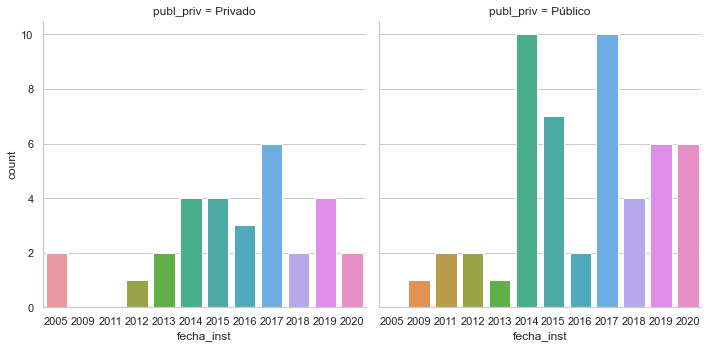

In [35]:
g = sns.catplot(x="fecha_inst" , col="publ_priv" , data=techos_solares , kind= "count" )

En concordacia con la primer visualización, en este countplot se puede observar que se desarrolló más la instalación de techos Solares en el sector Público, no asi en el Privado.

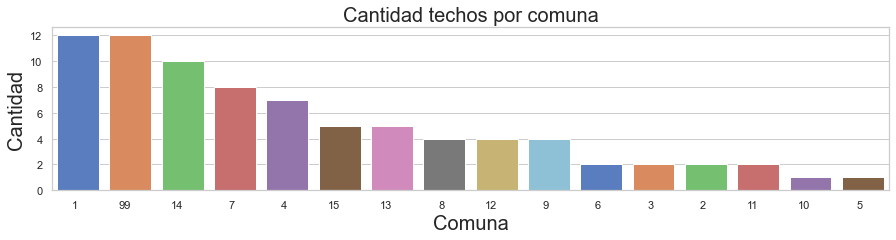

In [36]:
# Guardamos los indices de los comunas
idx_top = techos_solares['comuna'].value_counts(ascending=False).index[:]

plt.figure(figsize=(15,3))
# Indicamos la columna 'comuna', de los datos 'techos_solares', en el orden 'idx_top'
g = sns.countplot(x="comuna", data=techos_solares,
                  order=idx_top,
                  palette = "muted")
g.set_xticklabels(g.get_xticklabels(), ha="right")
plt.title('Cantidad techos por comuna', size = 20)
plt.xlabel("Comuna", size = 20)
plt.ylabel("Cantidad", size = 20)
plt.show()

Podemos observar que la comuna con mayor cantidad de techos solares es la 1, seguido de la 14.


Nota: Se recuerda que el "99" se puso de manera arbitraria a los techos que no contaban con la especificación del barrio o la comuna a la que pertenecen. Más adelante podremos identificar cuales son.

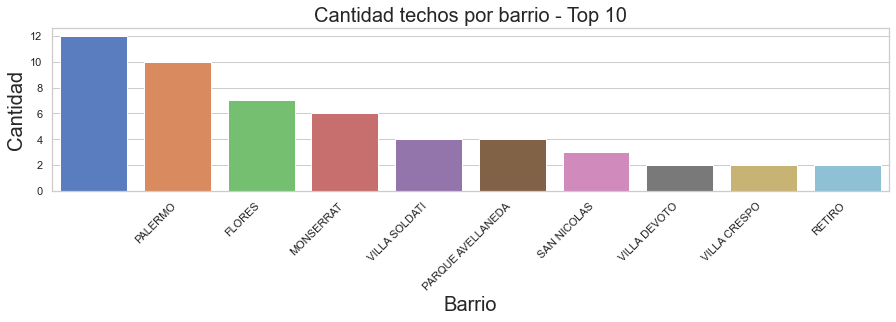

In [37]:
# top
top_n = 10
# Guardamos los indices de los top_n de barrios
idx_top = techos_solares['nombre_barrio'].value_counts(ascending=False).index[0:top_n]

plt.figure(figsize=(15,3))
# Indicamos la columna 'barrio', de los datos 'techos_solares', en el orden 'idx_top'
g = sns.countplot(x="nombre_barrio", data=techos_solares,
                  order=idx_top,
                  palette = "muted")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right")
plt.title('Cantidad techos por barrio - Top 10', size = 20)
plt.xlabel("Barrio", size = 20)
plt.ylabel("Cantidad", size = 20)
plt.show()

Aquí se puede obserbar el top 10 de barrios que poseen mas techos instalados en la actualidad, siendo Palermo con 10 techos el que más tiene.

Nota: Nuevamente se aclara que los 12 techos representados en la primera columna corresponden a los techos sin identificación de comuna o barrio.

In [38]:
sns.set_theme(style="white")

<AxesSubplot:title={'center':'Tipo de techos solares por comuna'}, xlabel='Longitud', ylabel='Latitud'>

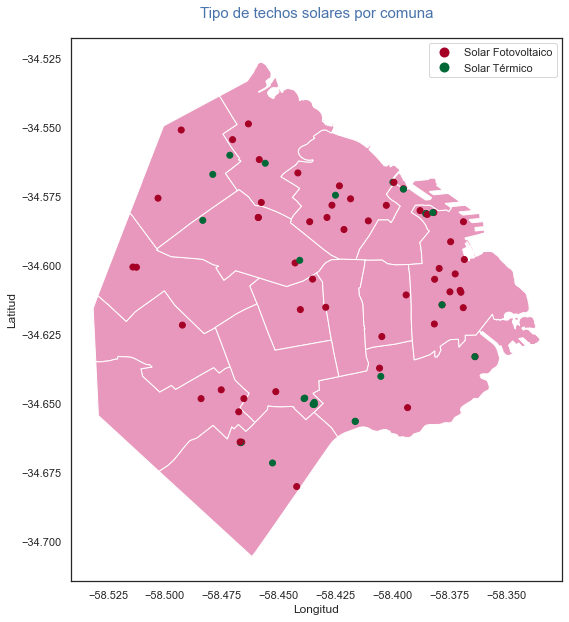

In [39]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Control del título y los ejes
ax.set_title('Tipo de techos solares por comuna', 
             pad = 20, 
             fontdict={'fontsize':15, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Mostrar el mapa finalizado
techos_solares.plot(column='tipo_tecnologia', cmap='RdYlGn', ax=ax, zorder=15, legend='True')

# Cargar un mapa base 
comunas = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson"
comunas = gpd.read_file(comunas)
comunas.plot(ax=ax, color='#e898bc', zorder=5)

Arriba podemos observar el mapa de la ciudad de Buenos Aires dividido por comunas en donde se localizaron la totalidad de los techos solares (termicos y fotovoltaicos) de la ciudad.

<AxesSubplot:title={'center':'Techos solares por año de instalación'}, xlabel='Longitud', ylabel='Latitud'>

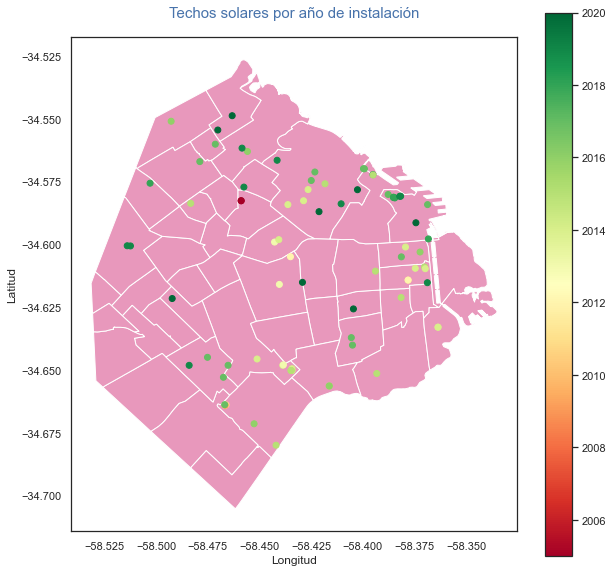

In [40]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))

# Control del título y los ejes
ax.set_title('Techos solares por año de instalación', 
             pad = 20, 
             fontdict={'fontsize':15, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Mostrar el mapa finalizado
techos_solares.plot(column='fecha_inst', cmap='RdYlGn', ax=ax, zorder=15, legend='True')

# Cargar un mapa base 
barrios = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson"
barrios = gpd.read_file(barrios)
barrios.plot(ax=ax, color='#e898bc', zorder=5)

Podemos visualizar como se fue desarrollando la instalación de los techos solares en la ciudad de Buenos Aires, siendo el primero antes del 2006. Se puede observar como fueron tomando más relevancia con el correr de los años. 

<AxesSubplot:title={'center':'Techos solares por comuna'}, xlabel='Longitud', ylabel='Latitud'>

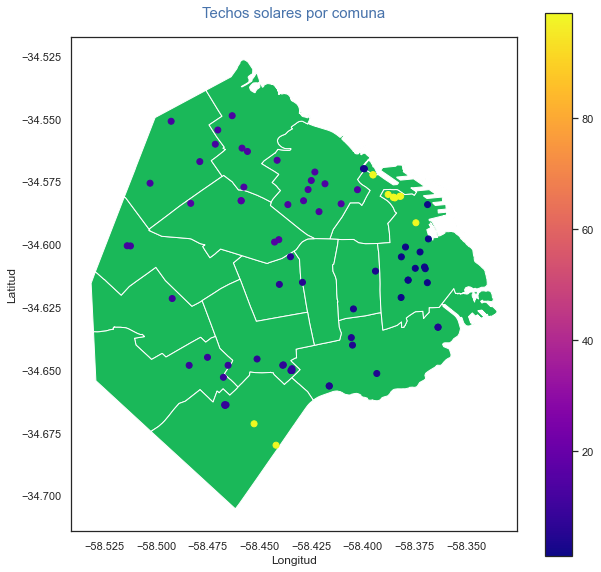

In [41]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))
 
# Mostrar el mapa finalizado
techos_solares.plot(column='comuna',cmap='plasma', ax=ax, zorder=15, legend='True')


# Control del título y los ejes
ax.set_title('Techos solares por comuna', 
             pad = 20, 
             fontdict={'fontsize':15, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Cargar un mapa base 
comunas = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson"
comunas = gpd.read_file(comunas)
comunas.plot(ax=ax, color='#1ab859', zorder=5)

En esta visualización se puede identificar a que comuna realmente pertenecen los techos asignados de manera arbitraria a la "Comuna 99".

<AxesSubplot:title={'center':'Mitigacion anual de CO2'}, xlabel='Longitud', ylabel='Latitud'>

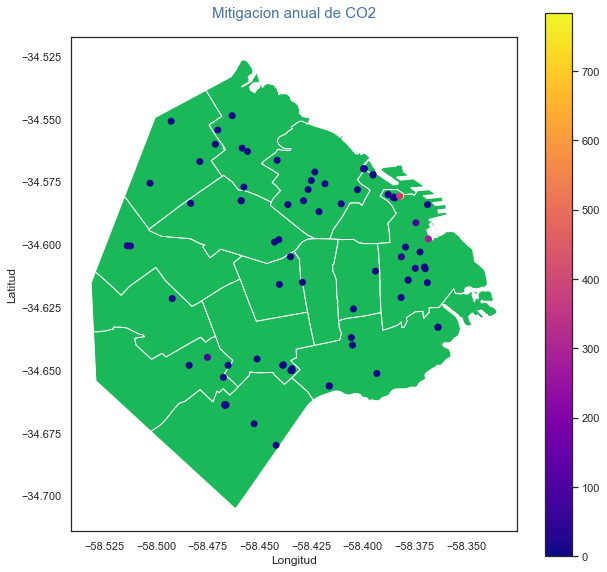

In [43]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(10, 10))
 
# Mostrar el mapa finalizado
techos_solares.plot(column='mitig_an_tCO2eq',cmap='plasma', ax=ax, zorder=15, legend='True')


# Control del título y los ejes
ax.set_title('Mitigacion anual de CO2',
             pad = 20, 
             fontdict={'fontsize':15, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Cargar un mapa base 
comunas = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/comunas/CABA_comunas.geojson"
comunas = gpd.read_file(comunas)
comunas.plot(ax=ax, color='#1ab859', zorder=5)

Aqui podemos observar la mitigacion anual de CO2 en Toneladas de CO2 equivalente al año, que representa el valor estimado de emisiones de gases de efecto invernadero que se evitan emitir a la atmósfera debido a la generación de energía eléctrica o calor a partir de la radiación solar.

# Aprendizaje No Supervizado - Clustering

### Seleccionamos las features con las que deseamos trabajar

In [44]:
x = techos_solares.drop(['geometry','publ_priv','tipo_tecnologia','tipo_conexion','nombre_barrio','comuna'],axis=1)
x.head(2)

,Horiz,Vert,fecha_inst,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq
0,-58.466210,-34.663907,2011,31025.0,13.96,310250.0,139.60
1,-58.374663,-34.609518,2014,48400.0,23.47,338800.0,164.29


### Pre procesamiento

In [45]:
scaler = preprocessing.StandardScaler().fit(x)
scaler

StandardScaler()

In [46]:
# Se guardan los datos pre procesados en la variable "xscal"
xscal = scaler.transform(x)  

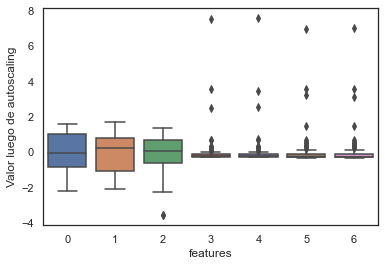

In [47]:
# Visualizacion de los cuantiles luego de auto escalarlos.
sns.boxplot(data = pd.DataFrame(xscal))
plt.xlabel("features")
plt.ylabel("Valor luego de autoscaling")
plt.show()

### Medición de performance

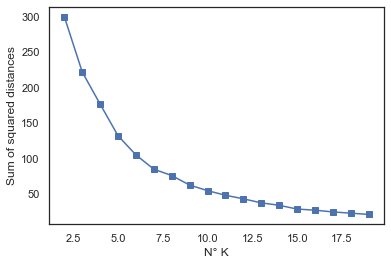

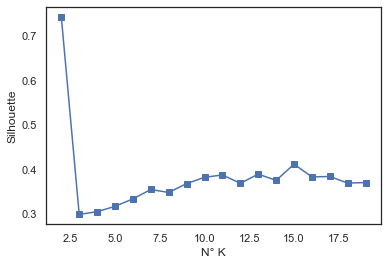

In [48]:
dist_cent = []
sill_list = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=3).fit(xscal)
    sill_score = silhouette_score(xscal,kmeans.labels_)
    sill_list.append(sill_score)
    dist_cent.append(kmeans.inertia_)
plt.plot(range(2, 20), dist_cent, marker='s');
plt.xlabel('N° K')
plt.ylabel('Sum of squared distances')
plt.show()
plt.plot(range(2, 20), sill_list, marker='s');
plt.xlabel('N° K')
plt.ylabel('Silhouette')
plt.show()

Con la curva del Silhouette podremos estimar que numero Cluster es conveniente elegir para realizar el aprendizaje No supervisado.

## K Mean

In [60]:
# Generamos un modelo de K means con 7 clusters
kmeans = KMeans(n_clusters=7, random_state=0).fit(xscal)

In [61]:
# Observamos las labels de cluster que se asignaron a cada muestra
kmeans.labels_

array([4, 6, 0, 0, 6, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 4, 2, 4, 4,
       6, 6, 0, 4, 4, 4, 4, 4, 4, 4, 5, 2, 4, 4, 5, 4, 2, 2, 5, 5, 4, 2,
       2, 5, 5, 5, 5, 6, 6, 4, 6, 5, 4, 4, 5, 5, 5, 5, 4, 3, 5, 2, 5, 5,
       5, 1, 3, 5, 5, 2, 2, 2, 2, 2, 5, 5, 2, 4, 2])

In [62]:
# Visualización de los centroides finales de cada cluster
kmeans.cluster_centers_

array([[-0.38995323,  0.45221756, -1.43366851, -0.23849913, -0.23866901,
        -0.21325306, -0.21384163],
       [ 1.09663982,  0.77871107,  1.02930047,  7.54933565,  7.5972381 ,
         6.98098312,  7.01633413],
       [-1.32717421,  0.98699613,  0.74571769, -0.17045613, -0.1701856 ,
        -0.24732711, -0.24801031],
       [ 1.25948115,  0.53081841,  0.86387718,  3.03057853,  2.97934896,
         3.40411148,  3.35506929],
       [-0.60150879, -1.39396306, -0.39333982, -0.19016042, -0.19003325,
        -0.1517439 , -0.15198055],
       [ 0.70345189,  0.64054914,  0.66694469, -0.09097909, -0.0893649 ,
        -0.09866737, -0.09709916],
       [ 1.12372156, -0.37860875, -0.45950914, -0.24027466, -0.23914205,
        -0.23574687, -0.2322186 ]])

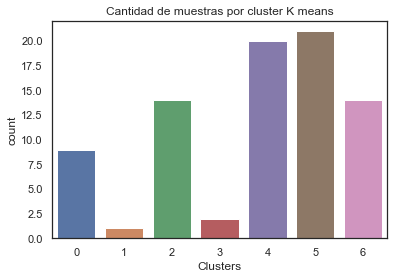

In [63]:
# Contamos cuantas muestras quedaron en cada cluster
sns.countplot(kmeans.labels_)
plt.title("Cantidad de muestras por cluster K means")
plt.xlabel("Clusters")
plt.show()

## Clustering Jerárquico (con scipy)

In [64]:
# Visualización del dendograma scipy
Z = linkage(xscal, 'ward')

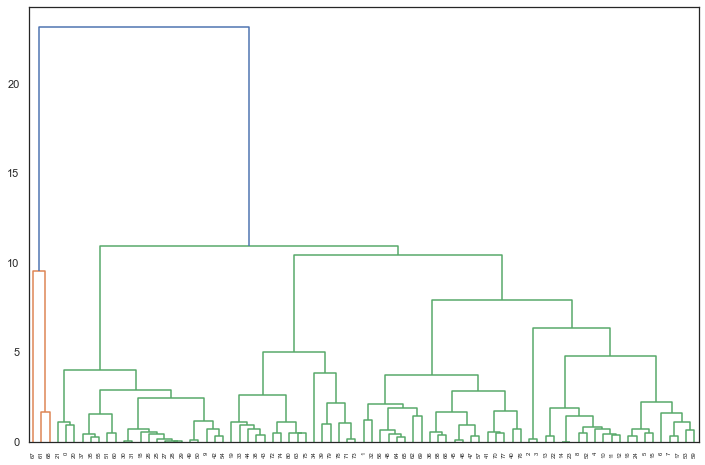

In [65]:
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.show()

## Clustering jerárquico con Scikit Learn

In [66]:
# Generamos un modelo agrupamiento jerárquico con 7 clusters
hierclus = AgglomerativeClustering(n_clusters=7).fit(xscal)

In [67]:
# Observamos las labels de cluster que se asignaron a cada muestra
hierclus.labels_

array([2, 5, 6, 6, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 5, 0, 0, 2, 5, 2, 0, 0, 5, 5, 2, 0,
       0, 5, 5, 5, 5, 2, 2, 2, 1, 1, 2, 2, 5, 5, 5, 1, 2, 3, 5, 0, 5, 5,
       5, 4, 3, 5, 5, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0], dtype=int64)

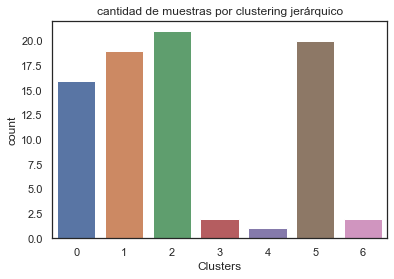

In [68]:
# visualizamos cuantas muestras quedaron en cada cluster
sns.countplot(hierclus.labels_)
plt.title("cantidad de muestras por clustering jerárquico")
plt.xlabel("Clusters")
plt.show()

## Medición de la calidad de clusters con Silhouette Score

In [69]:
# Silhouette score utilizando las etiquetas obtenidas de K-means
metrics.silhouette_score(xscal, kmeans.labels_, metric='euclidean')

0.3480045314072583

In [70]:
# Silhouette score utilizando las etiquetas obtenidas de Hierarchical clustering
metrics.silhouette_score(xscal, hierclus.labels_, metric='euclidean')

0.33634559702041245

### Conclusión

Luego de correr el modelo en varias ocasiones realizando la selección de distintos Hiperparametros el mayor resultado de Silhoutte Score obtenido fue de 0.34 aproximadamente para ambos modelos. Se considera que dicho valor es muy bajo con lo cual los distintos clusters generados no estan bien definidos o que tienen una baja similaridad respecto a su mismo cluster.

# Aprendizaje No Supervizado - Clustering (2)

Para intentar mejorar la performance del modelo, se suma otro data set. En este caso se seleccionó uno que contiene la cantidad de población por cada barrio de la ciudad de Buenos Aires.

In [71]:
# Importamos el dataset
poblacion = pd.read_csv('caba_pob_barrios_2010.csv')
# Normalizamos los textos
poblacion['BARRIO']= poblacion['BARRIO'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

poblacion = poblacion.set_index('BARRIO')
poblacion.head()

,POBLACION
BARRIO,
AGRONOMIA,13912
ALMAGRO,131699
BALVANERA,138926
BARRACAS,89452
BELGRANO,126267


### Trabajo con el data set original para agruparlo por barrio

In [72]:
techos_solares_barrio = techos_solares.assign(Profit=1)
techos_solares_barrio = techos_solares_barrio.rename(columns={"Profit":"cantidad_techos"})

techos_solares_barrio.nombre_barrio.replace('', np.nan, inplace = True )
techos_solares_barrio.nombre_barrio.replace(np.nan, 'Sin especificar', inplace = True )
techos_solares_barrio = techos_solares_barrio[techos_solares_barrio['nombre_barrio'] != 'Sin especificar' ]

techos_solares_barrio.head()

,geometry,Horiz,Vert,publ_priv,tipo_tecnologia,fecha_inst,comuna,tipo_conexion,energia_an_kwh,mitig_an_tCO2eq,energia_acum_kwh,mitig_acum_tCO2eq,nombre_barrio,cantidad_techos
0,POINT (-58.46621 -34.66391),-58.466210,-34.663907,Público,Solar Fotovoltaico,2011,8,On-Grid,31025.0,13.96,310250.0,139.60,VILLA SOLDATI,1
1,POINT (-58.37466 -34.60952),-58.374663,-34.609518,Público,Solar Fotovoltaico,2014,1,On-Grid,48400.0,23.47,338800.0,164.29,MONSERRAT,1
2,POINT (-58.45891 -34.58261),-58.458915,-34.582613,Privado,Solar Fotovoltaico,2005,15,On-Grid,2635.0,1.18,42160.0,18.88,CHACARITA,1
3,POINT (-58.45891 -34.58261),-58.458915,-34.582613,Privado,Solar Fotovoltaico,2005,15,Off-Grid,186.0,0.08,2976.0,1.34,CHACARITA,1
4,POINT (-58.37235 -34.60303),-58.372352,-34.603032,Privado,Solar Fotovoltaico,2016,1,On-Grid,735.0,0.33,3675.0,1.65,SAN NICOLAS,1


In [73]:
# Realizamos una pivot table para visualizar los techos por barrio
techos_pivot_barrio = pd.pivot_table(techos_solares_barrio,values = 'cantidad_techos', index = techos_solares_barrio.nombre_barrio.values, aggfunc = np.sum)
techos_pivot_barrio = techos_pivot_barrio.sort_values('cantidad_techos', ascending=False)
techos_pivot_barrio.head()

,cantidad_techos
PALERMO,10
FLORES,7
MONSERRAT,6
VILLA SOLDATI,4
PARQUE AVELLANEDA,4


In [74]:
# Realizamos una pivot table para visualizar la energia anual generada
techos_pivot_barrio1 = pd.pivot_table(techos_solares_barrio,values = 'energia_an_kwh', index = techos_solares_barrio.nombre_barrio.values, aggfunc = np.sum)
techos_pivot_barrio1 = techos_pivot_barrio1.sort_values('energia_an_kwh', ascending=False)
techos_pivot_barrio1.head()

,energia_an_kwh
RETIRO,628255.0
PARQUE AVELLANEDA,281650.0
SAN NICOLAS,127467.0
PALERMO,118879.0
VILLA DEVOTO,111600.0


In [75]:
# Realizamos una pivot table para visualizar la mitigacion anual de CO2
techos_pivot_barrio2 = pd.pivot_table(techos_solares_barrio,values = 'mitig_an_tCO2eq', index = techos_solares_barrio.nombre_barrio.values, aggfunc = np.sum)
techos_pivot_barrio2 = techos_pivot_barrio2.sort_values('mitig_an_tCO2eq', ascending=False)
techos_pivot_barrio2.head()

,mitig_an_tCO2eq
RETIRO,282.72
PARQUE AVELLANEDA,126.75
SAN NICOLAS,57.36
PALERMO,53.49
VILLA DEVOTO,50.22


### Unificamos las tablas generadas y el nuevo dataset de población por barrio

In [76]:
# Hacemos el join de las tablas generadas 
techos_por_barrio = techos_pivot_barrio.join(techos_pivot_barrio1)
techos_por_barrio = techos_por_barrio.join(techos_pivot_barrio2)
techos_por_barrio = techos_por_barrio.join(poblacion)
techos_por_barrio.head()

,cantidad_techos,energia_an_kwh,mitig_an_tCO2eq,POBLACION
PALERMO,10,118879.0,53.49,226534
FLORES,7,13178.0,5.93,164310
MONSERRAT,6,92896.0,43.49,39914
VILLA SOLDATI,4,64422.0,28.98,46779
PARQUE AVELLANEDA,4,281650.0,126.75,53229


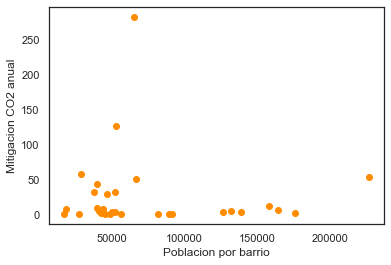

In [78]:
# Vemos si existe una correlación entre la cantidad de Población y la mitigación de CO2 anual
# Visualizamos los datos en un scatterplot
plt.scatter(techos_por_barrio['POBLACION'],techos_por_barrio['mitig_an_tCO2eq'],color="darkorange")
plt.xlabel('Poblacion por barrio')
plt.ylabel('Mitigacion CO2 anual')
plt.show()

No hay una relación aparente entre estos parámetros.

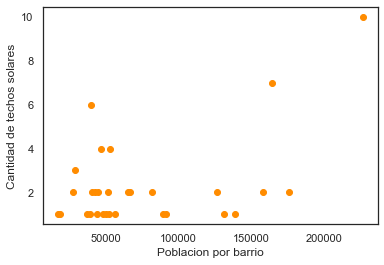

In [79]:
# Vemos si existe una correlación entre la cantidad de Poblacion por barrio y la cantidad de techos por barrio
# Visualizamos los datos en un scatterplot
plt.scatter(techos_por_barrio['POBLACION'],techos_por_barrio['cantidad_techos'],color="darkorange")
plt.xlabel('Poblacion por barrio')
plt.ylabel('Cantidad de techos solares')
plt.show()

En este caso tampoco observamos una relación entre estas variables.

### Seleccionamos las features con las que deseamos trabajar

In [81]:
x1 = techos_por_barrio.iloc[:,:4]

In [82]:
x1.head()

,cantidad_techos,energia_an_kwh,mitig_an_tCO2eq,POBLACION
PALERMO,10,118879.0,53.49,226534
FLORES,7,13178.0,5.93,164310
MONSERRAT,6,92896.0,43.49,39914
VILLA SOLDATI,4,64422.0,28.98,46779
PARQUE AVELLANEDA,4,281650.0,126.75,53229


### Pre procesamiento

In [83]:
scaler = preprocessing.StandardScaler().fit(x1)
scaler

StandardScaler()

In [84]:
# nuestros datos pre-procesados los guardamos en "xscal"
x1scal = scaler.transform(x1)  

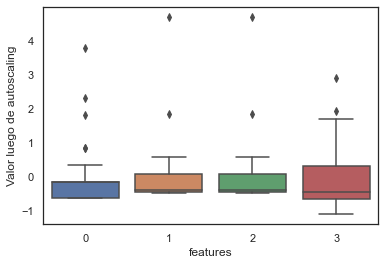

In [85]:
# visualizamos nuestros datos luego del autoscaling
sns.boxplot(data = pd.DataFrame(x1scal))
plt.xlabel("features")
plt.ylabel("Valor luego de autoscaling")
plt.show()

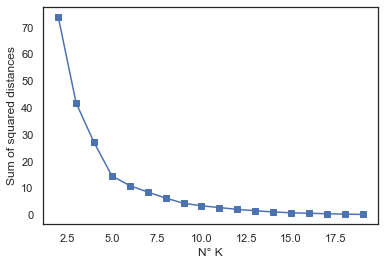

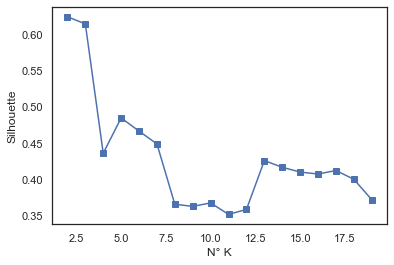

In [86]:
dist_cent = []
sill_list = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=3).fit(x1scal)
    sill_score = silhouette_score(x1scal,kmeans.labels_)
    sill_list.append(sill_score)
    dist_cent.append(kmeans.inertia_)
plt.plot(range(2, 20), dist_cent, marker='s');
plt.xlabel('N° K')
plt.ylabel('Sum of squared distances')
plt.show()
plt.plot(range(2, 20), sill_list, marker='s');
plt.xlabel('N° K')
plt.ylabel('Silhouette')
plt.show()

Se puede observar que tanto para 3 como para 5 cluster, el valor de Silhouette es mayor al obtenido en el modelo anterior.

## K Mean

In [98]:
# Generamos un modelo de K means con 3 clusters con los datos autoscalados
kmeans = KMeans(n_clusters=3, random_state=0).fit(x1scal)

In [99]:
# Se observan las labels de los cluster asignadas a cada muestra
kmeans.labels_

array([2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [89]:
# Visualización de los centroides finales de cada cluster.
kmeans.cluster_centers_

array([[ 0.34389282,  3.27228736,  3.2702915 , -0.30717055],
       [-0.26075389, -0.25697626, -0.25672141, -0.15378176],
       [ 3.0459078 ,  0.06840406,  0.06708688,  2.30633337]])

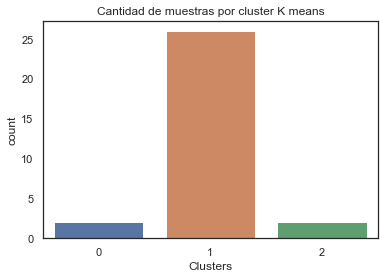

In [90]:
# Visualización de cuantas muestras quedaron en cada cluster
sns.countplot(kmeans.labels_)
plt.title("Cantidad de muestras por cluster K means")
plt.xlabel("Clusters")
plt.show()

## Clustering Jerárquico (con scipy)

In [91]:
# visualización del dendograma con scipy
Z = linkage(x1scal, 'ward')

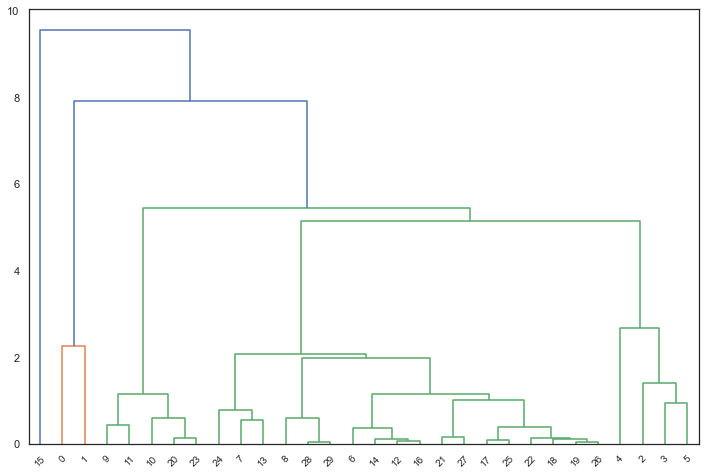

In [92]:
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.show()

## Clustering jerárquico con Scikit Learn

In [93]:
# Generamos un modelo jerárquico con 3 clusters
hierclus = AgglomerativeClustering(n_clusters=3).fit(x1scal)

In [94]:
# Observamos las labels de clusters asignadas a cada muestra
hierclus.labels_

array([2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

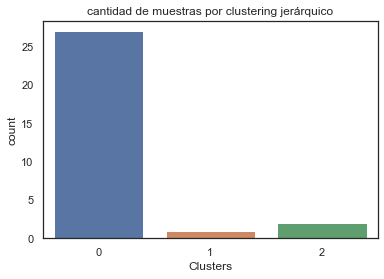

In [95]:
# visualizamos en pantalla cuantas muestras quedaron en cada cluster
sns.countplot(hierclus.labels_)
plt.title("cantidad de muestras por clustering jerárquico")
plt.xlabel("Clusters")
plt.show()

## Medición de la calidad de clusters con Silhouette Score

In [96]:
# Silhouette score utilizando las etiquetas obtenidas de K-means
metrics.silhouette_score(x1scal, kmeans.labels_, metric='euclidean')

0.6148292653814037

In [97]:
# Silhouette score utilizando las etiquetas obtenidas de Hierarchical clustering
metrics.silhouette_score(x1scal, hierclus.labels_, metric='euclidean')

0.601473646051652

### Conclusión

Podemos observar los valores de Silhouette obtenidos y concluir que las muestras estan aceptablemente definidas. A su vez, tambien podemos observar que los cluster se encuentran muy dispares, obteniendo solo 1 muestra para el Cluster 1 y 2 muestras para el Cluster 2. 

Concluimos que con los datos trabajados en este análisis, realizar un proceso de aprendizaje No supervisado en el cual se intenta realizar la segmentación de un conjunto de muestras, no es suficiente. 

Para poder continuar con desarrollo del aprendizaje no supervisado y obtener un resultado mas contundente, se sugiere agregar mas información al análisis, como por ejemplo el de "Calidad de aire" donde se brinda información diaria de los niveles medios de monóxido de carbono, dióxido de nitrógeno y material particulado respirable menor a 10 micrones medidos en las 4 estaciones de monitoreo de Buenos Aires.